Training Step: 1031  | total loss: 0.69145 | time: 17.192s
| Adam | epoch: 003 | loss: 0.69145 - acc: 0.5309 -- iter: 21952/21962
Training Step: 1032  | total loss: 0.69164 | time: 18.247s
| Adam | epoch: 003 | loss: 0.69164 - acc: 0.5294 | val_loss: 0.68870 - val_acc: 0.5540 -- iter: 21962/21962
--
[0.6888375878334045, 0.6906519532203674, 0.6948485970497131, 0.6959933042526245, 0.6951944828033447, 0.6883115768432617, 0.683929443359375, 0.7345010042190552, 0.7176287770271301, 0.707006573677063, 0.7001323699951172, 0.6975802183151245, 0.7020671367645264, 0.701627254486084, 0.6998299360275269, 0.6977840662002563, 0.6963982582092285, 0.6951745748519897, 0.6945867538452148, 0.6940961480140686, 0.6931905746459961, 0.6931832432746887, 0.6924009323120117, 0.6921061873435974, 0.6911249160766602, 0.6914390921592712, 0.6914946436882019, 0.6886588335037231, 0.690636157989502, 0.6925440430641174, 0.6950065493583679, 0.6936931014060974, 0.6918625235557556, 0.6904886960983276, 0.6939504742622375, 0.

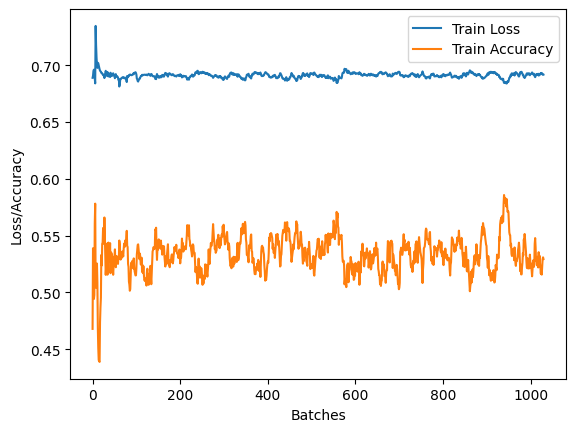

100%|██████████| 2538/2538 [00:00<00:00, 5488.14it/s]


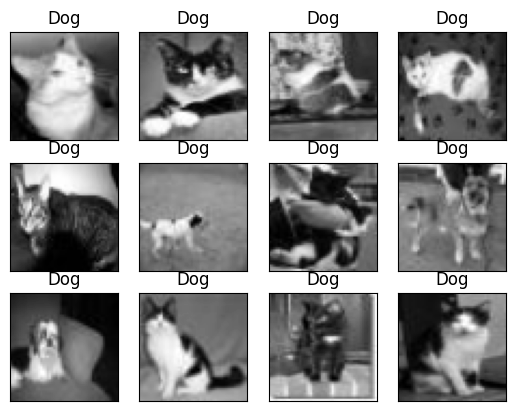

100%|██████████| 2538/2538 [00:02<00:00, 992.63it/s] 


In [2]:
import cv2                 # working with, mainly resizing, images
import numpy as np         # dealing with arrays
import os                  # dealing with directories
from random import shuffle # mixing up or currently ordered data that might lead our network astray in training.
from tqdm import tqdm      # a nice pretty percentage bar for tasks. Thanks to viewer Daniel Bühler for this suggestion
import matplotlib.pyplot as plt

TRAIN_DIR = '../dogs-cats-mini/train'
TEST_DIR = '../dogs-cats-mini/test'
IMG_SIZE = 50
LR = 1e-3

MODEL_NAME = 'dogsvscats-{}-{}.model'.format(LR, '2conv-basic') # just so we remember which saved model is which, sizes must match

def label_img(img):
    word_label = img.split('.')[-3]
    # conversion to one-hot array [cat,dog]
    #                            [much cat, no dog]
    if word_label == 'cat': return [1,0]
    #                             [no cat, very doggo]
    elif word_label == 'dog': return [0,1]

def create_train_data():
    training_data = []
    for img in tqdm(os.listdir(TRAIN_DIR)):
        label = label_img(img)
        path = os.path.join(TRAIN_DIR,img)
        img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        training_data.append([np.array(img),np.array(label)])
    shuffle(training_data)
    # np.save('train_data.npy', training_data)
    return training_data

def process_test_data():
    testing_data = []
    for img in tqdm(os.listdir(TEST_DIR)):
        path = os.path.join(TEST_DIR,img)
        img_num = img.split('.')[0]
        img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        testing_data.append([np.array(img), img_num])
        
    shuffle(testing_data)
    # np.save('test_data.npy', testing_data)
    return testing_data

train_data = create_train_data()
# If you have already created the dataset:
#train_data = np.load('train_data.npy')

import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression

import tensorflow as tf
tf.compat.v1.reset_default_graph()
convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 128, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 2, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir='log')

# if os.path.exists('{}.meta'.format(MODEL_NAME)):
#     model.load(MODEL_NAME)
#     print('model loaded!')

train = train_data[:-500]
test = train_data[-500:]

X = np.array([i[0] for i in train]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
Y = [i[1] for i in train]

test_x = np.array([i[0] for i in test]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
test_y = [i[1] for i in test]


# Initialize lists to store training loss and accuracy
train_loss = []
train_acc = []

# Define a custom callback to record training loss and accuracy during training
class CustomCallback(tflearn.callbacks.Callback):
    def __init__(self):
        self.losses = []
        self.accs = []

    def on_batch_end(self, training_state, snapshot=False):
        # Append training loss and accuracy to the lists
        self.losses.append(training_state.loss_value)
        self.accs.append(training_state.acc_value)

custom_callback = CustomCallback()
model.fit({'input': X}, {'targets': Y}, n_epoch=3, validation_set=({'input': test_x}, {'targets': test_y}), 
    snapshot_step=500, show_metric=True, run_id=MODEL_NAME, callbacks=custom_callback)

# LEARNING CURVE
train_loss = custom_callback.losses[2:]
train_acc = custom_callback.accs[2:]

print(train_loss)
print(train_acc)

plt.plot(train_loss, label='Train Loss')
plt.plot(train_acc, label='Train Accuracy')
plt.xlabel('Batches')
plt.ylabel('Loss/Accuracy')
plt.legend()
plt.show()

# model.save(MODEL_NAME)

import matplotlib.pyplot as plt

# if you need to create the data:
test_data = process_test_data()
# if you already have some saved:
# test_data = np.load('test_data.npy')

fig=plt.figure()

for num,data in enumerate(test_data[:12]):
    # cat: [1,0]
    # dog: [0,1]
    
    img_num = data[1]
    img_data = data[0]
    
    y = fig.add_subplot(3,4,num+1)
    orig = img_data
    data = img_data.reshape(IMG_SIZE,IMG_SIZE,1)
    #model_out = model.predict([data])[0]
    model_out = model.predict([data])[0]
    
    if np.argmax(model_out) == 1: str_label='Dog'
    else: str_label='Cat'
        
    y.imshow(orig,cmap='gray')
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()

with open('submission_file.csv','w') as f:
    f.write('id,label\n')
            
with open('submission_file.csv','a') as f:
    for data in tqdm(test_data):
        img_num = data[1]
        img_data = data[0]
        orig = img_data
        data = img_data.reshape(IMG_SIZE,IMG_SIZE,1)
        model_out = model.predict([data])[0]
        f.write('{},{}\n'.format(img_num,model_out[1]))